In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
n_classes = 10

In [3]:
# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomato/tomato ds/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 11209 files belonging to 10 classes.


In [4]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomato/tomato ds/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 4798 files belonging to 10 classes.


In [5]:
class_names = train_ds.class_names
# Prefetch datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [6]:
# Define Inception module
def inception_module(x, f1, f3_r, f3, f5_r, f5, pool_proj):
    conv1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    conv3 = layers.Conv2D(f3_r, (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3)

    conv5 = layers.Conv2D(f5_r, (1, 1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5)

    pool_proj_layer = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj_layer = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(pool_proj_layer)

    output = layers.concatenate([conv1, conv3, conv5, pool_proj_layer], axis=-1)
    return output

In [7]:
# Define GoogLeNet-like architecture
input_layer = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception modules
x = inception_module(x, 64, 96, 128, 16, 32, 32)
x = inception_module(x, 128, 128, 192, 32, 96, 64)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 192, 96, 208, 16, 48, 64)
x = inception_module(x, 160, 112, 224, 24, 64, 64)
x = inception_module(x, 128, 128, 256, 24, 64, 64)
x = inception_module(x, 112, 144, 288, 32, 64, 64)
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 256, 160, 320, 48, 128, 128)
x = inception_module(x, 384, 192, 384, 48, 128, 128)

# Final layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output_layer = layers.Dense(n_classes, activation='softmax')(x)

In [8]:
# Build and compile the model
model = models.Model(input_layer, output_layer)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [9]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                 

 Total params: 6,048,330 (23.07 MB)

 Trainable params: 6,048,330 (23.07 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.9595 - loss: 0.1189
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9591 - loss: 0.1243
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.9539 - loss: 0.1371
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.9175 - loss: 1.2709
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.4060 - loss: 1.7250
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.5931 - loss: 1.1715
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.6983 - loss: 0.8540
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.7631 - loss: 0.6527
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8185 - loss: 0.5148
Epoch 10/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8406 - loss: 0.4560
Epoch 11/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8695 - loss: 0.3785
Epoch 12/50
351/351 ━━━━━━━━━━

In [18]:
# Evaluate the model on test set
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7648 - loss: 0.6706
Test Accuracy: 77.05%


Text(0.5, 1.0, 'Training Accuracy')

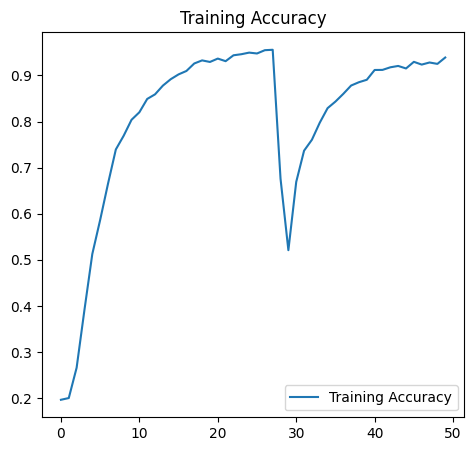

In [12]:

# Plot training/test accuracy and loss
acc = history.history['accuracy']
loss = history.history['loss']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')


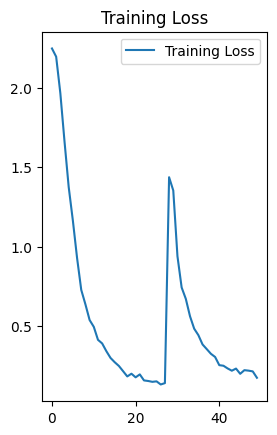

In [13]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

First image to predict:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: Tomato_Spider_mites_Two_spotted_spider_mite


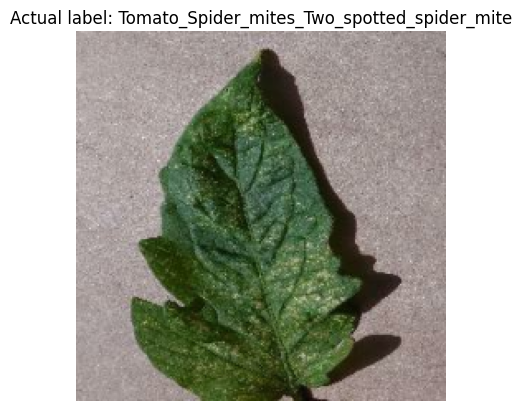

In [14]:
# Display first image prediction from test set
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict:")
    plt.imshow(first_image)
    plt.title(f"Actual label: {class_names[first_label]}")
    plt.axis('off')

    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

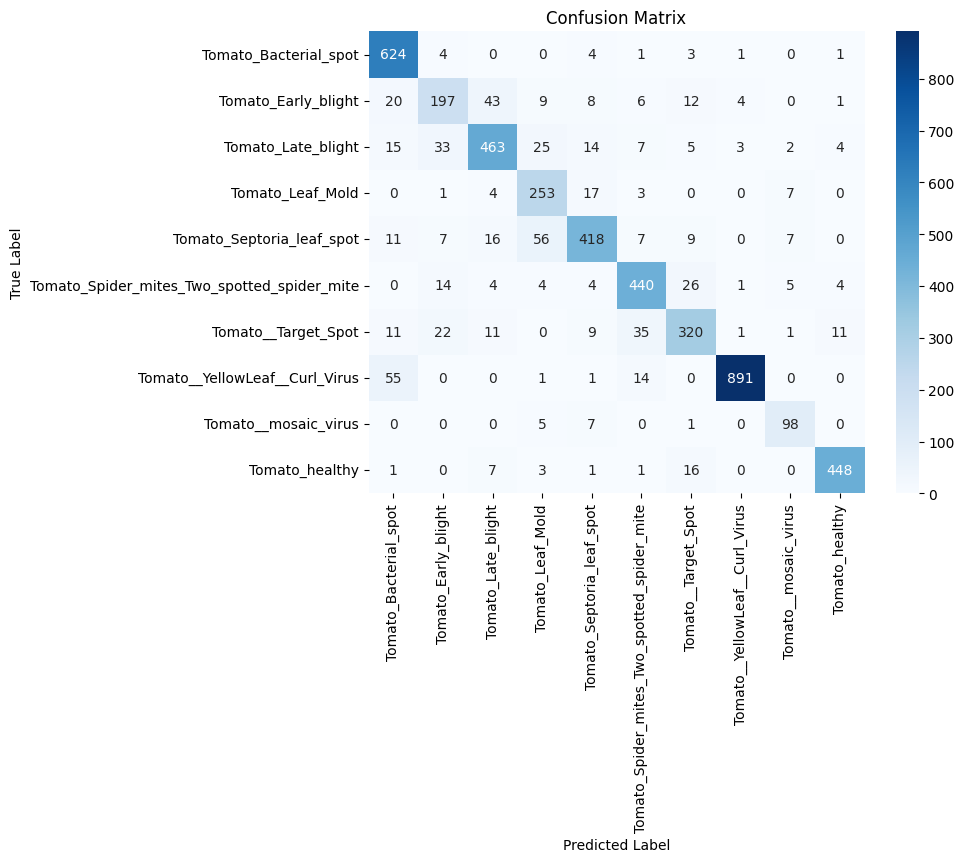

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.85      0.98      0.91       638
                        Tomato_Early_blight       0.71      0.66      0.68       300
                         Tomato_Late_blight       0.84      0.81      0.83       571
                           Tomato_Leaf_Mold       0.71      0.89      0.79       285
                  Tomato_Septoria_leaf_spot       0.87      0.79      0.82       531
Tomato_Spider_mites_Two_spotted_spider_mite       0.86      0.88      0.87       502
                        Tomato__Target_Spot       0.82      0.76      0.79       421
             Tomato__YellowLeaf__Curl_Virus       0.99      0.93      0.96       962
                       Tomato__mosaic_virus       0.82      0.88      0.85       111
                             Tomato_healthy       0.96      0.94      0.95       477

                                   accuracy                    

In [15]:
# Confusion matrix and classification report
y_true = []
y_pred = []
for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=-1))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

In [16]:
model.save("/kaggle/working/tomato_model.h5") 